In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
import os.path
from preprocessing import *
from skorch import NeuralNetRegressor
from torch import nn, optim
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'preprocessing'

In [2]:
X_file = "data/X_matrix.csv"
Y_file = "data/Y_matrix.csv"

print("Loading and preprocessing the data...")

# Load the column names (header)
column_names = np.genfromtxt(X_file, delimiter=',', max_rows=1, dtype=str)[1:]  # Skip the first column if it's row names

# Read the first line of the file to determine the number of columns
with open(X_file, 'r') as f:
    first_line = f.readline()
    end_column_index = len(first_line.split(','))  # Count the number of columns in the first line

# Load the row names (index) from the first column and the data (excluding first column)
data = np.loadtxt(X_file, delimiter=',', skiprows=1, usecols=range(1, end_column_index))
row_names = np.loadtxt(X_file, delimiter=',', skiprows=1, usecols=0, dtype=str)

# Create the DataFrame
x2_df = pd.DataFrame(data, index=row_names, columns=column_names)
x2_df = pd.DataFrame(data, columns=column_names)

print("moving to y")
y2_df = pd.read_csv(Y_file)
print("three")


x_data_f = x2_df.drop(x2_df.columns[0], axis=1)
y_data_f = y2_df.drop(y2_df.columns[0], axis=1)

x_data_f, y_data_f = preprocessed_data(x_data_f, y_data_f, y=True)




Loading and preprocessing the data...
moving to y
three
The DataFrame does not contain any NaN values.
1
The DataFrame does not contain any NaN values.
2
The DataFrame does not contain any NaN values.
3


In [3]:
x_data_save1 = pd.DataFrame(x_data_f)
x_data_save1.to_pickle("data/x_simple_NN.pkl")
y_data_save1 = pd.DataFrame(y_data_f)
y_data_save1.to_pickle("data/y_simple_NN.pkl")

In [28]:
x_data_f = pd.read_pickle("data/x_simple_NN.pkl")
y_data_f = pd.read_pickle("data/y_simple_NN.pkl")

In [ ]:
#V2

# Préparation des données
print("Préparation des données...")

# Number of input features
n_input_features = x_data_f.shape[1]

# Define an enhanced neural network
class EnhancedRegressionNet(nn.Module):
    def __init__(self, n_input_features, dropout_rate, n_neurons_1=1024, n_neurons_2=512):
        super(EnhancedRegressionNet, self).__init__()
        self.fc1 = nn.Linear(n_input_features, n_neurons_1)  # n_input_features
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(n_neurons_1, n_neurons_2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(n_neurons_2, 1)  # Output layer remains 2D

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x  # Do not squeeze the output; output remains shape [batch_size, 1]

# Ensure both x_data_f and y_data_f are converted to float32
x_data_f = x_data_f.astype(np.float32)  # Cast features to float32
y_data_f = y_data_f.astype(np.float32)  # Cast target to float32

# Define scoring callbacks for training and validation loss
train_loss = EpochScoring(scoring='neg_mean_squared_error', on_train=True, name='train_loss', lower_is_better=False)
valid_loss = EpochScoring(scoring='neg_mean_squared_error', name='valid_loss', lower_is_better=False)

# Neural Network Regressor
net = NeuralNetRegressor(
    module=EnhancedRegressionNet,
    module__n_input_features=n_input_features,  # n_input_features
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__batch_size=32,
    callbacks=[EarlyStopping(patience=5)],
    verbose=1
)

# Parameter grid
param_grid = {
    'module__dropout_rate': [0.01, 0.1, 0.2],
    'lr': [ 0.0001, 0.00001],
    'max_epochs': [100, 150]
}

# GridSearchCV
grid_search = GridSearchCV(net, param_grid=param_grid, cv=KFold(n_splits=5), scoring='neg_mean_squared_error', n_jobs=2)

Préparation des données...


#something to try
param_grid = {
    'module__dropout_rate': [0.1, 0.3, 0.5],
    'module__n_neurons_1': [128, 256, 512, 1024],
    'module__n_neurons_2': [64, 128, 256, 512],
    'lr': [0.0001, 0.001, 0.01],
    'max_epochs': [100, 150, 200],
    'optimizer__weight_decay': [0, 1e-5, 1e-4, 1e-3],
    'iterator_train__batch_size': [16, 32, 64],
}


In [30]:
y_data_f = y_data_f.to_numpy()
print(y_data_f.shape)

(792, 1)


In [40]:
# NO NEED TO RUN, the best parameters are printed

# Fit the grid search
grid_search.fit(x_data_f.values, y_data_f)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

In [38]:
best_params = {
    'module__dropout_rate': 0.01,  # Single value for dropout rate
    'lr': 0.0001,                # Single value for learning rate
    'max_epochs': 100            # Single value for max epochs
}

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1       -0.6939       -0.0303  12.1359
      2       -0.0921       -0.0208  11.8062
      3       -0.0459       -0.0243  11.9286
      4       -0.0265       -0.0220  12.0306
      5       -0.0155       -0.0229  11.8958
      6       -0.0128       -0.0139  11.9207
      7       -0.0113       -0.0111  12.0382
      8       -0.0098       -0.0086  12.1345
      9       -0.0070       -0.0089  12.4075
     10       -0.0053       -0.0095  12.3776
     11       -0.0043       -0.0085  12.0532
     12       -0.0039       -0.0107  12.0604
     13       -0.0036       -0.0090  12.4203
     14       -0.0043       -0.0105  12.2521
     15       -0.0033       -0.0108  11.9985
Stopping since valid_loss has not improved in the last 5 epochs.
Mean Squared Error: 0.002688939915969968
R2 score: 0.33119046688079834


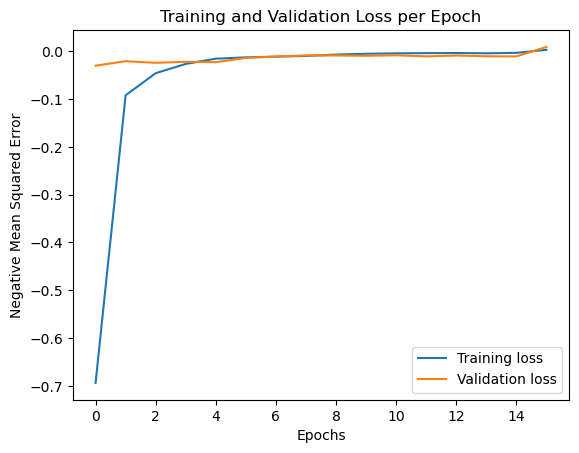

In [ ]:
# Training of the model
best_net = NeuralNetRegressor(
    module=EnhancedRegressionNet,
    module__n_input_features=n_input_features,
    module__n_neurons_1=1024,                   # Neurons in the first hidden layer
    module__n_neurons_2=512,
    module__dropout_rate=best_params['module__dropout_rate'],
    criterion=nn.MSELoss,
    max_epochs=best_params['max_epochs'],
    optimizer=optim.Adam,
    lr=best_params['lr'],
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=5), train_loss, valid_loss],
    verbose=1
)

# Train the final model
best_net.fit(x_data_f.values, y_data_f)

# Predictions
Y_pred = best_net.predict(x_data_f.values)

# Reshape predictions for consistency (if needed)
Y_pred = Y_pred.reshape(-1, 1)

# Create a DataFrame with predictions
id_array = np.arange(1, len(Y_pred) + 1)
final_df = pd.DataFrame({
    'ID': id_array,
    'division_rate': Y_pred.flatten()
})

# Save the new DataFrame to a CSV file
final_csv = final_df.to_csv("Data\\results_nn3.csv", index=False)

# Evaluate the model
mse = mean_squared_error(y_data_f, Y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_data_f, Y_pred)
print(f'R2 score: {r2}')

# Extract training and validation loss for a plot
train_losses = best_net.history[:, 'train_loss']
valid_losses = best_net.history[:, 'valid_loss']

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Negative Mean Squared Error')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.savefig("Data\\NNplot_nn3.png")
plt.show()


In [42]:
import pickle

with open("model_NN.pkl", "wb") as file:
    pickle.dump(best_net, file)
print("Model saved as model.pkl")

Model saved as model.pkl


In [3]:
#you can start here

with open("model_NN.pkl", "rb") as file:
    loaded_model = pickle.load(file)
print("Model loaded")

NameError: name 'pickle' is not defined

In [ ]:
import joblib
from sklearn.externals import joblib  # If older versions of sklearn

# Load the trained neural network
trained_nn = loaded_model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

# Use the NN to generate predictions
y_pred = trained_nn.predict(x_data_f.values)

# Train a Random Forest on the original input features
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_data_f, y_pred)

# Display feature importances from Random Forest
importances = rf.feature_importances_
for feature_name, importance in zip(x_data_f.columns, importances):
    print(f"Feature: {feature_name}, Importance: {importance}")

# Alternatively, train a Lasso regression model
lasso = Lasso(alpha=0.01)  # Regularization parameter
lasso.fit(x_data_f, y_pred)

# Display feature coefficients from Lasso
for feature_name, coef in zip(x_data_f.columns, lasso.coef_):
    print(f"Feature: {feature_name}, Coefficient: {coef}")


In [12]:
import shap
import numpy as np



# SHAP Explainer: Use KernelExplainer for skorch models
explainer = shap.KernelExplainer(best_net.predict, shap.sample(x_data_f, 20))  # Sample 100 rows for the baseline

# Compute SHAP values for a subset of data
shap_values = explainer.shap_values(x_data_f[:20])  # Calculate for the first 200 rows

# Visualize SHAP values
shap.summary_plot(shap_values, x_data_f[:20], feature_names=x_data_f.columns)


  0%|          | 0/20 [00:44<?, ?it/s]


KeyboardInterrupt: 

In [8]:
#imporatnces with SHAP

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create SHAP explainer
explainer = shap.DeepExplainer(best_net, x_data_f.values.astype(np.float32))

# Initialize an array to store SHAP values
shap_values = []

# Progress bar
with tqdm(total=len(x_data_f), desc="Computing SHAP Values") as pbar:
    for i in range(len(x_data_f)):
        shap_value = explainer.shap_values(x_data_f.values[i:i+1].astype(np.float32))  # Compute SHAP for one sample
        shap_values.append(shap_value[0])  # SHAP for the first output class
        pbar.update(1)
print("1")

# Convert SHAP values to a numpy array
shap_values = np.vstack(shap_values)

# Summarize feature importance
feature_importances = pd.DataFrame({
    "Feature": x_data_f.columns,
    "Importance": np.abs(shap_values).mean(axis=0)  # Mean absolute SHAP values
}).sort_values(by="Importance", ascending=False)

# Select the top 10 features
top_10_features = feature_importances.head(10)

# Plot
plt.figure(figsize=(15, 9))
plt.barh(top_10_features["Feature"], top_10_features["Importance"], align="center")
plt.gca().invert_yaxis()
plt.xlabel("Mean Absolute SHAP Values")
plt.title("Top 10 Most Important Features (SHAP)")
plt.tight_layout()
plt.savefig("Data\\SHAP_Feature_Importance_Plot.png")
plt.show()

# Display top 10 features
print(top_10_features)

c:\Users\paola\anaconda3\envs\MLCourse\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#importances with captum

import torch
from captum.attr import IntegratedGradients
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Convert data to PyTorch tensors
x_tensor = torch.tensor(x_data_f.values.astype(np.float32))
y_tensor = torch.tensor(y_data_f.astype(np.float32))

# Initialize Integrated Gradients
ig = IntegratedGradients(best_net)

# Initialize an array to store attributions
attributions = []

# Progress bar
with tqdm(total=len(x_tensor), desc="Computing Integrated Gradients") as pbar:
    for i in range(len(x_tensor)):
        attr, _ = ig.attribute(x_tensor[i:i+1], target=0, return_convergence_delta=True)  # Compute IG for one sample
        attributions.append(attr.detach().numpy())
        pbar.update(1)

# Aggregate absolute values of attributions across samples for each feature
attributions = np.vstack(attributions)
feature_importances = np.abs(attributions).mean(axis=0)

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    "Feature": x_data_f.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Select the top 10 features
top_10_features = feature_importance_df.head(10)

# Plot
plt.figure(figsize=(15, 9))
plt.barh(top_10_features["Feature"], top_10_features["Importance"], align="center")
plt.gca().invert_yaxis()
plt.xlabel("Integrated Gradients Importance")
plt.title("Top 10 Most Important Features (Captum)")
plt.tight_layout()
plt.savefig("Data\\Captum_Feature_Importance_Plot.png")
plt.show()

# Display top 10 features
print(top_10_features)

Computing Integrated Gradients:   0%|          | 0/792 [00:00<?, ?it/s]


TypeError: <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=EnhancedRegressionNet(
    (fc1): Linear(in_features=334898, out_features=128, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.012, inplace=False)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.012, inplace=False)
    (fc3): Linear(in_features=128, out_features=1, bias=True)
  ),
) is not a callable object

In [16]:
'''
In a neural network, you don't directly get "feature importances" like in tree-based models (e.g., Random Forest or XGBoost). 
However, you can estimate feature importance by analyzing how sensitive the model's predictions are to changes in each feature. 
This method is often referred to as "permutation importance" or "feature sensitivity analysis."

Here's a Python script to compute and visualize the top 10 most important features based on permutation importance:
'''

from sklearn.inspection import permutation_importance

# Calculate permutation importance
results = permutation_importance(
    best_net,  # Trained model
    x_data_f.values.astype(np.float32),  # Input data
    y_data_f.astype(np.float32),  # Target values
    scoring="neg_mean_squared_error",  # Scoring metric
    n_repeats=15,  # Number of permutations
    random_state=42,  # For reproducibility
    n_jobs=-1
)

# Create a DataFrame for feature importance
feature_importances = pd.DataFrame({
    "Feature": x_data_f.columns,
    "Importance": results.importances_mean
}).sort_values(by="Importance", ascending=False)

# Select the top 10 features
top_10_features = feature_importances.head(10)

# Plot the top 10 features
plt.figure(figsize=(15, 9))
plt.barh(top_10_features["Feature"], top_10_features["Importance"], align="center")
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel("Mean Importance")
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.savefig("Data\\Feature_Importance_Plot.png")
plt.show()


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.